<a href="https://colab.research.google.com/github/jscriven0218/DS-Live-022122/blob/main/MakingItInHollywood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **HOLLYWOOD, HERE WE COME**

# Business Understanding


Deciding to get into the film industry is a big first step!  It's an exciting new adventure.  Next step is determining what films we'd like to make to be successful!

# Data Understanding

IMDb, the Internet Movie Database, is a website containing all information regarding films, including cast, genres, runtimes, rating and production crew. Starting this new movie studio with a new production crew, we concentrated on the information that we can mimic in our own films - genre and runtimes.

While IMDb records and data can provide instruction on making a movie that audiences love, our company also needs to earn a profit in our new endeavor.  Box Office records for 2010 through 2018 were collected which we will use to accomplish our goal of succeeding in Hollywood.

In [32]:
import numpy as np
import pandas as pd
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [33]:
!unzip -o im.db.zip
conn = sqlite3.connect('im.db')

Archive:  im.db.zip
  inflating: im.db                   


In [34]:
# wanted to look at the available tables from the IMDB data

IMDB = pd.read_sql("""
SELECT *
FROM sqlite_master
""", conn)

IMDB[IMDB['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [4]:
Box = pd.read_csv('bom.movie_gross.csv')
Box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [ ]:
Box['foreign_gross'] = Box['foreign_gross'].str.replace(',','')
Box['foreign_gross'] = Box['foreign_gross'].astype(float)

In [ ]:
# create a total_gross so we know the full profits

Box['foreign_gross'] = Box['foreign_gross'].fillna(0)
Box['domestic_gross'] = Box['domestic_gross'].fillna(0)
Box['total_gross_inmil'] = (Box['domestic_gross'] + Box['foreign_gross'])/1000000
Box

,title,studio,domestic_gross,foreign_gross,year,total_gross_inmil
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1067.0000
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1025.5000
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,960.3000
3,Inception,WB,292600000.0,535700000.0,2010,828.3000
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,752.6000
...,...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,0.0,2018,0.0062
3383,Edward II (2018 re-release),FM,4800.0,0.0,2018,0.0048
3384,El Pacto,Sony,2500.0,0.0,2018,0.0025
3385,The Swan,Synergetic,2400.0,0.0,2018,0.0024


In [ ]:
# convert csv of Box Office data to an SQL table

from sqlalchemy import create_engine
engine = create_engine('sqlite:///im.db')
Box.to_sql('Box', engine, index=False, if_exists='replace')

3387

In [6]:
# collecting general information on the tables that appear useful

q = """
SELECT *
FROM movie_basics
"""
Basics = pd.read_sql(q, conn)
Basics

DatabaseError: Execution failed on sql '
SELECT *
FROM movie_basics
': no such table: movie_basics

In [ ]:
# want to understand the different genre types

q = """
SELECT DISTINCT genres, COUNT(genres) AS count
FROM movie_basics
GROUP BY genres
ORDER BY count DESC
"""
pd.read_sql(q, conn)

,genres,count
0,Documentary,32185
1,Drama,21486
2,Comedy,9177
3,Horror,4372
4,"Comedy,Drama",3519
...,...,...
1081,"Action,Animation,History",1
1082,"Action,Animation,Documentary",1
1083,"Action,Animation,Biography",1
1084,"Action,Adventure,Musical",1


# Data Preparation and Analysis

After examining all of the information available, we used the Titles in both the IMDb tables and the Box Office data to pool together the information provided by either source.  Throught the process, we cleaned up the data by dropping unncessary columns, removing rows that contained missing information and, in the genre column, cleaning up the multi-genre groups.

Because the Box Office data had far fewer records (3,387) than IMDb (nearing 150,000), we first checked to see if there was enough relation between the earnings datapoint in the Box Office data and the average rating from IMDb.  Meaning, could we use the rating for those films which we do not have earnings.  While the graph showed a slight skew left, the statistic was not enough to do so.

In [ ]:
q = """
SELECT Basics.movie_id, Box.title, total_gross_inmil, runtime_minutes, genres, averagerating
FROM movie_basics AS Basics
JOIN Box AS Box
ON Basics.primary_title = Box.title
JOIN movie_ratings AS Ratings
ON Basics.movie_id = Ratings.movie_id
"""
df_withearnings = pd.read_sql(q, conn)
df_withearnings = df_withearnings.drop_duplicates(subset=['movie_id'])
df_withearnings

,movie_id,title,total_gross_inmil,runtime_minutes,genres,averagerating
0,tt0315642,Wazir,1.100000,103.0,"Action,Crime,Drama",7.1
1,tt0337692,On the Road,8.744000,124.0,"Adventure,Drama,Romance",6.1
2,tt0359950,The Secret Life of Walter Mitty,188.100000,114.0,"Adventure,Comedy,Drama",7.3
3,tt0365907,A Walk Among the Tombstones,53.200000,114.0,"Action,Crime,Drama",6.5
4,tt0369610,Jurassic World,652.301019,124.0,"Action,Adventure,Sci-Fi",7.0
...,...,...,...,...,...,...
3022,tt9392532,Neighbors,270.700000,90.0,"Comedy,Drama",7.6
3023,tt9447594,The Gambler,39.300000,121.0,"Action,Sci-Fi,Thriller",6.1
3024,tt9816988,Gold,14.900000,NaN,Drama,5.2
3025,tt9851050,Sisters,105.000000,NaN,"Action,Drama",4.7


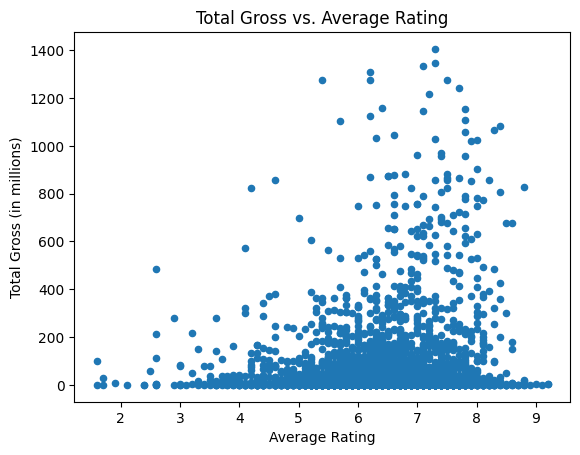

In [ ]:
# before using the average rating as a measure of the 'best' films for us to create, since our true goal is to make money, want to determine that there is a positive relationship between total gross earnings and average rating

ax = df_withearnings.plot(x='averagerating', y='total_gross_inmil', kind='scatter')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Total Gross (in millions)')
ax.set_title('Total Gross vs. Average Rating')
plt.show()


In [ ]:
results = sm.OLS(df_withearnings['total_gross_inmil'], df_withearnings['averagerating']).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      total_gross_inmil   R-squared (uncentered):                   0.178
Model:                            OLS   Adj. R-squared (uncentered):              0.178
Method:                 Least Squares   F-statistic:                              655.4
Date:                Thu, 29 May 2025   Prob (F-statistic):                   5.19e-131
Time:                        06:37:20   Log-Likelihood:                         -19861.
No. Observations:                3025   AIC:                                  3.972e+04
Df Residuals:                    3024   BIC:                                  3.973e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
averagerating    12.2424      0.478     25.601      0.000      11.305      13.180
==============================================================================
Omnibus:                     2377.207   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41959.987
Skew:                           3.742   Prob(JB):                         0.00
Kurtosis:                      19.640   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The data included information on the genre of the movies.  There were many different genres, but we cleaned up the group and concentrated on the top 6 genres, when ranked by sample size.  These 6 genres are Action, Comedy, Documentary, Drama, Horror and Thriller.

In [ ]:
df_withearnings['genres'].value_counts()

,count
genres,
Drama,317
"Comedy,Drama",133
"Comedy,Drama,Romance",132
"Drama,Romance",112
Documentary,110
...,...
"Action,Animation,Crime",1
"Crime,Mystery",1
"Documentary,Mystery",1


In [ ]:
print(df_withearnings['genres'].value_counts().sum())

3018


In [ ]:
df_withearnings['genres'] = df_withearnings['genres'].astype(str).fillna('')
movie_info_single_genre = df_withearnings[~df_withearnings['genres'].str.contains(',')]
movie_info_single_genre

,movie_id,title,total_gross_inmil,runtime_minutes,genres,averagerating
15,tt0427152,Dinner for Schmucks,86.8000,114.0,Comedy,5.9
27,tt0455323,Being Flynn,0.5400,102.0,Drama,6.4
32,tt0460890,The Only Living Boy in New York,2.5240,89.0,Drama,6.3
36,tt0466893,Margaret,0.0465,150.0,Drama,6.5
72,tt0795461,Scary Movie 5,78.4000,86.0,Comedy,3.5
...,...,...,...,...,...,...
3015,tt8919194,Genius,5.7000,NaN,Drama,6.2
3016,tt9000062,Maggie,0.1870,88.0,Drama,6.4
3020,tt9174880,Eden,0.0655,97.0,Drama,6.7
3024,tt9816988,Gold,14.9000,NaN,Drama,5.2


In [ ]:
genre_count = movie_info_single_genre.value_counts('genres')
genre_count = genre_count.sort_values(ascending=False)
genre_count

,count
genres,
Drama,317
Documentary,110
Comedy,95
Horror,29
Thriller,25
Action,18
None,7
Romance,6
Animation,5


In [ ]:
low_genres = genre_count[genre_count < 10]
low_genres

,count
genres,
Romance,6
Animation,5
Crime,4
Family,4
Mystery,2
Sci-Fi,2
Fantasy,2
Adventure,1
Biography,1


In [ ]:
movie_info_single_genre = movie_info_single_genre[~movie_info_single_genre['genres'].isin(low_genres.index)]
movie_info_single_genre = movie_info_single_genre[~movie_info_single_genre['genres'].str.contains('None')]
movie_info_single_genre = movie_info_single_genre.dropna(subset=['runtime_minutes'])
movie_info_single_genre

,movie_id,title,total_gross_inmil,runtime_minutes,genres,averagerating
15,tt0427152,Dinner for Schmucks,86.8000,114.0,Comedy,5.9
27,tt0455323,Being Flynn,0.5400,102.0,Drama,6.4
32,tt0460890,The Only Living Boy in New York,2.5240,89.0,Drama,6.3
36,tt0466893,Margaret,0.0465,150.0,Drama,6.5
72,tt0795461,Scary Movie 5,78.4000,86.0,Comedy,3.5
...,...,...,...,...,...,...
3013,tt8851190,Red,199.0000,90.0,Drama,8.1
3014,tt8917752,Joy,101.2000,99.0,Drama,6.5
3016,tt9000062,Maggie,0.1870,88.0,Drama,6.4
3020,tt9174880,Eden,0.0655,97.0,Drama,6.7


In [ ]:
genre_rating = movie_info_single_genre.groupby('genres')['averagerating'].mean()
genre_count = movie_info_single_genre.value_counts('genres')
genre_earning = movie_info_single_genre.groupby('genres')['total_gross_inmil'].mean()

genre_info = pd.DataFrame({'rating': genre_rating, 'count': genre_count, 'earnings': genre_earning})
genre_info = genre_info.reset_index()
genre_info

,genres,rating,count,earnings
0,Action,6.220000,15,28.629547
1,Comedy,5.733333,93,51.725056
2,Documentary,7.203774,106,33.604891
3,Drama,6.672848,302,19.182283
4,Horror,4.955172,29,80.452438
5,Thriller,5.804348,23,36.279509


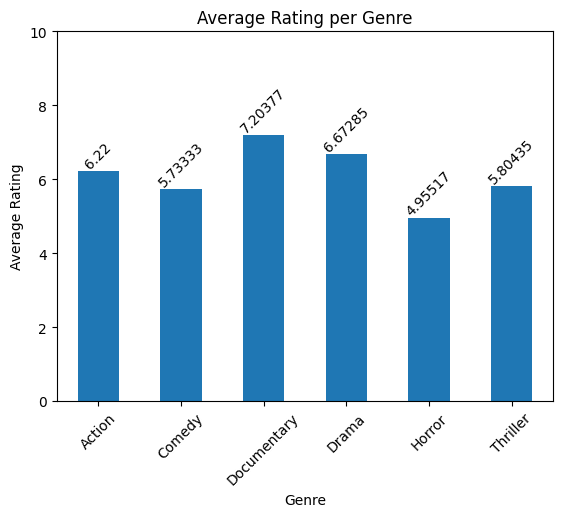

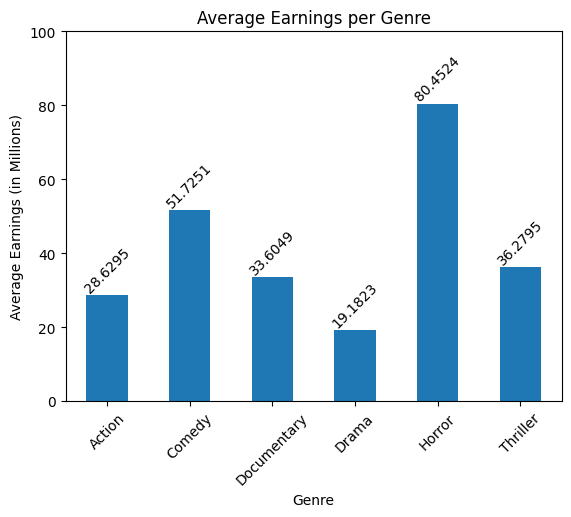

In [ ]:
ax = genre_info.plot(x='genres', y='rating', kind='bar', legend=False)
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating per Genre')
plt.bar_label(ax.containers[0], rotation = 45)
plt.xticks(rotation=45)
plt.ylim(0,10)
plt.show()

ax = genre_info.plot(x='genres', y='earnings', kind='bar', legend=False)
ax.set_xlabel('Genre')
ax.set_ylabel('Average Earnings (in Millions)')
ax.set_title('Average Earnings per Genre')
plt.bar_label(ax.containers[0], rotation = 45)
plt.xticks(rotation=45)
plt.ylim(0,100)
plt.show()


After looking at the genres, we concentrated on the runtime of the movies to determine if that had an affect on the rating or earnings.

In [ ]:
movie_info_runtime = movie_info_single_genre
movie_info_runtime

,movie_id,title,total_gross_inmil,runtime_minutes,genres,averagerating
15,tt0427152,Dinner for Schmucks,86.8000,114.0,Comedy,5.9
27,tt0455323,Being Flynn,0.5400,102.0,Drama,6.4
32,tt0460890,The Only Living Boy in New York,2.5240,89.0,Drama,6.3
36,tt0466893,Margaret,0.0465,150.0,Drama,6.5
72,tt0795461,Scary Movie 5,78.4000,86.0,Comedy,3.5
...,...,...,...,...,...,...
3013,tt8851190,Red,199.0000,90.0,Drama,8.1
3014,tt8917752,Joy,101.2000,99.0,Drama,6.5
3016,tt9000062,Maggie,0.1870,88.0,Drama,6.4
3020,tt9174880,Eden,0.0655,97.0,Drama,6.7


In [ ]:
print(movie_info_runtime['runtime_minutes'].min())
print(movie_info_runtime['runtime_minutes'].max())
print(movie_info_runtime['averagerating'].min())
print(movie_info_runtime['averagerating'].max())

25.0
181.0
1.7
9.2


In [ ]:
runtime_rating = movie_info_runtime.groupby('runtime_minutes')['averagerating'].mean()
runtime_count = movie_info_runtime.value_counts('runtime_minutes')
runtime_earning = movie_info_runtime.groupby('runtime_minutes')['total_gross_inmil'].mean()

runtime_info = pd.DataFrame({'rating': runtime_rating, 'count': runtime_count, 'earnings': runtime_earning})
runtime_info = runtime_info.reset_index()
runtime_info

,runtime_minutes,rating,count,earnings
0,25.0,7.900000,1,68.600000
1,40.0,6.966667,3,159.586667
2,41.0,6.900000,1,16.000000
3,44.0,7.300000,1,9.300000
4,46.0,7.950000,2,12.460650
...,...,...,...,...
94,154.0,6.900000,1,5.434000
95,155.0,7.300000,2,0.190700
96,161.0,6.300000,1,0.250000
97,165.0,8.100000,2,22.344500


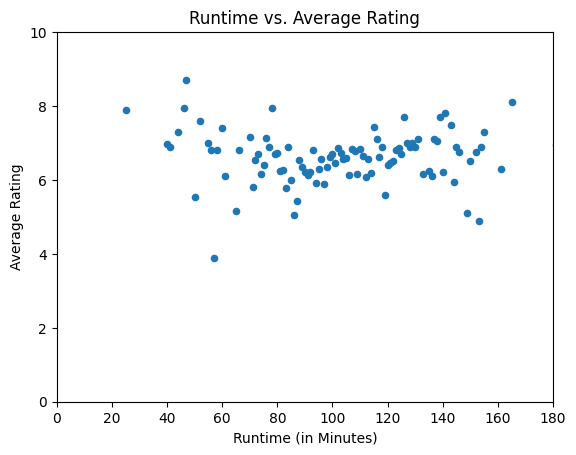

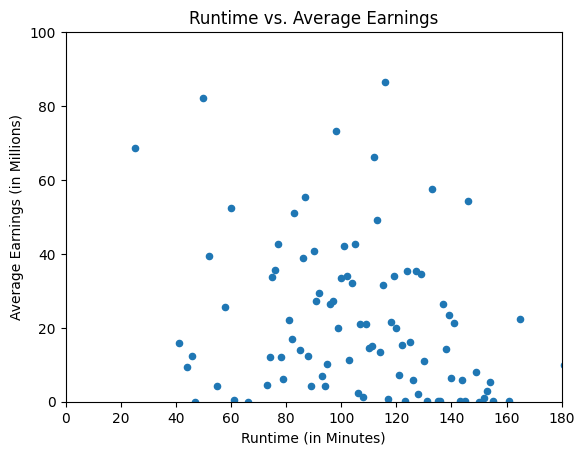

In [ ]:
ax = runtime_info.plot(x='runtime_minutes', y='rating', kind='scatter')
ax.set_xlabel('Runtime (in Minutes)')
ax.set_ylabel('Average Rating')
ax.set_title('Runtime vs. Average Rating')
plt.ylim(0,10)
plt.xlim(0,180)
plt.show()

ax = runtime_info.plot(x='runtime_minutes', y='earnings', kind='scatter')
ax.set_xlabel('Runtime (in Minutes)')
ax.set_ylabel('Average Earnings (in Millions)')
ax.set_title('Runtime vs. Average Earnings')
plt.ylim(0,100)
plt.xlim(0,180)
plt.show()

In [ ]:
final_withearnings = movie_info_runtime
final_withearnings

,movie_id,title,total_gross_inmil,runtime_minutes,genres,averagerating
15,tt0427152,Dinner for Schmucks,86.8000,114.0,Comedy,5.9
27,tt0455323,Being Flynn,0.5400,102.0,Drama,6.4
32,tt0460890,The Only Living Boy in New York,2.5240,89.0,Drama,6.3
36,tt0466893,Margaret,0.0465,150.0,Drama,6.5
72,tt0795461,Scary Movie 5,78.4000,86.0,Comedy,3.5
...,...,...,...,...,...,...
3013,tt8851190,Red,199.0000,90.0,Drama,8.1
3014,tt8917752,Joy,101.2000,99.0,Drama,6.5
3016,tt9000062,Maggie,0.1870,88.0,Drama,6.4
3020,tt9174880,Eden,0.0655,97.0,Drama,6.7


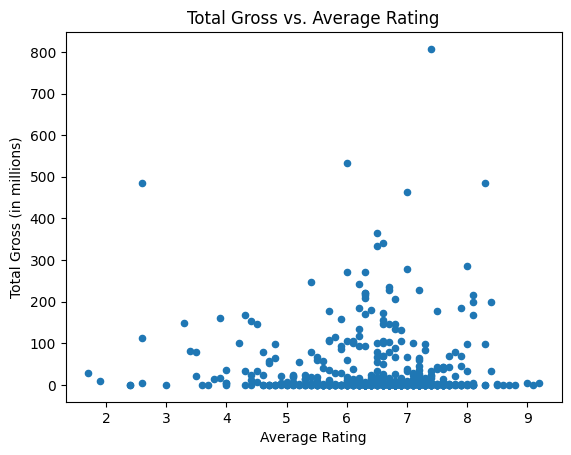

In [ ]:
ax = final_withearnings.plot(x='averagerating', y='total_gross_inmil', kind='scatter')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Total Gross (in millions)')
ax.set_title('Total Gross vs. Average Rating')
plt.show()

Finally, we generated an ANOVA table to show the probability that the factors we were examining (Genre, Average Rating and Runtime) are influential on the Earnings.  In line with the graphs above, the ANOVA shows that Genre is the most probable to have an influence on Earnings, then the Runtime was next probable and Average Rating was much less likely.

In [ ]:
final_withearnings_ANOVA = final_withearnings.drop(columns = ['movie_id', 'title'])

genre_mapping = {
    'Action':1,
    'Comedy':2,
    'Documentary':3,
    'Drama':4,
    'Horror':5,
    'Thriller':6
}

final_withearnings_ANOVA['genres'] = final_withearnings_ANOVA['genres'].map(genre_mapping)
final_withearnings_ANOVA


,total_gross_inmil,runtime_minutes,genres,averagerating
15,86.8000,114.0,2,5.9
27,0.5400,102.0,4,6.4
32,2.5240,89.0,4,6.3
36,0.0465,150.0,4,6.5
72,78.4000,86.0,2,3.5
...,...,...,...,...
3013,199.0000,90.0,4,8.1
3014,101.2000,99.0,4,6.5
3016,0.1870,88.0,4,6.4
3020,0.0655,97.0,4,6.7


In [ ]:
formula = 'total_gross_inmil ~ averagerating + runtime_minutes + C(genres)'
model = ols(formula, final_withearnings_ANOVA).fit()
table = sm.stats.anova_lm(model, typ=2)
print(table)

                       sum_sq     df         F    PR(>F)
C(genres)        1.360102e+05    5.0  4.854626  0.000235
averagerating    1.521078e+04    1.0  2.714598  0.099995
runtime_minutes  4.356755e+04    1.0  7.775305  0.005477
Residual         3.137862e+06  560.0       NaN       NaN


In [ ]:
formula = 'averagerating ~ runtime_minutes + C(genres)'
model = ols(formula, final_withearnings_ANOVA).fit()
table = sm.stats.anova_lm(model, typ=2)
print(table)

                     sum_sq     df          F        PR(>F)
C(genres)        200.853249    5.0  47.022518  1.326963e-40
runtime_minutes    6.793698    1.0   7.952492  4.971912e-03
Residual         479.254100  561.0        NaN           NaN


# Conclusion

As we open this new movie studio, we have two goals on which we will be concentrating: 1. Make a great movie!  The more our films are adored, the better our reputation and opportunity for growth. 2. Earn money.

This analysis lead to the conclusion that genre and runtime do have influence on the average rating and average earnings.  In order to succeed, we have come to the following recommendations:


*   **Stay away from genres that have opposite effects on ratings and earnings** As shown in the charts above, Horror movies made the most earnings in the Box Office records, but they also have lower ratings on IMDb.  On the other side of things, Drama films made less money, but were loved by the audience.  Further analysis in how reviewers rate films, such as looking at human reaction, production value, acting, etc., may be helpful in determining why this happens.
*   **Ratings don't determine earnings** For the good of our shareholders, the greater priority in this movie studio is making a profit.  Ratings have not necessarily corresponded to earnings in this analysis.  It would be interesting to see if there is any connection between the top group of high income and low ratings - are they sequels? do they have a significant actor in them?
*   **Watch your runtime** While runtime's probability of having an affect on earnings is not extremely high, it does have a larger probablilty of changing a film's rating.





